In [24]:
library(readr)
library(dplyr)
library(tidyr)
library(stringr)
library(lfe)
library(ggsci)
library(lubridate)
library(ggplot2)
library(doMC)
library(gridExtra)
library(urbnmapr)
library(viridis)
library(ggthemes)
library(ggsci)
library(ggpubr)
library(stargazer)
library(scales)
registerDoMC(4)

Loading required package: viridisLite


Attaching package: ‘viridis’


The following object is masked from ‘package:scales’:

    viridis_pal




In [2]:
fp  <- '/pool001/mfzhao/'
df  <- read_rds(str_c(fp, '/PROCESSED_DATA/panel_pre_xgr.RDS'))
WM2 <- read_rds(str_c(fp, 'PROCESSED_DATA/stateWM_v2.RDS'))

In [3]:
df %>%
    select(key,
           date, 
           cluster,
           n,
           log_mcbgv,
           log_pnchd,
           log_pgt1hafh, 
           log_ppthlt75,
           log_pgt2kmt,
           matches('new'),
           matches('unemp'),
           matches('^log_stalter_'), 
           matches('^[pt][rm][ca][px][01][0-9]$'),
           matches('^p[123]...$'),
           matches('stalter_p[123]...$'),
           matches('stalter[NF]'),
           matches('stalter_[pt][rm][ca][px][01][0-9]$'),
           matches('as_(st)?new')) -> df

In [4]:
cns <- colnames(df)
cns

[1] "key"                  "date"                 "cluster"             
 [4] "n"                    "log_mcbgv"            "log_pnchd"           
 [7] "log_pgt1hafh"         "log_ppthlt75"         "log_pgt2kmt"         
[10] "newcases"             "newdeaths"            "stnewcases"          
[13] "stnewdeaths"          "as_newcases"          "as_newdeaths"        
[16] "as_stnewcases"        "as_stnewdeaths"       "ct_unemp_rate"       
[19] "st_unemp_rate"        "log_stalter_mcbgv"    "log_stalter_pnchd"   
[22] "log_stalter_pgt1hafh" "log_stalter_ppthlt75" "log_stalter_pgt2kmt" 
[25] "prcp01"               "prcp02"               "prcp03"              
[28] "prcp04"               "prcp05"               "prcp06"              
[31] "prcp07"               "prcp08"               "prcp09"              
[34] "prcp10"               "tmax02"               "tmax03"              
[37] "tmax04"               "tmax05"               "tmax06"              
[40] "tmax07"               "tmax08"               "tmax09"              
[43] "tmax10"               "p1sdp"                "p2shp"               
[46] "p3rop"                "stalter_p1sdp"        "stalter_p2shp"       
[49] "stalter_p3rop"        "stalterNear_p1sdp"    "stalterNear_p2shp"   
[52] "stalterNear_p3rop"    "stalterFar_p1sdp"     "stalterFar_p2shp"    
[55] "stalterFar_p3rop"     "stalter_prcp01"       "stalter_prcp02"      
[58] "stalter_prcp03"       "stalter_prcp04"       "stalter_prcp05"      
[61] "stalter_prcp06"       "stalter_prcp07"       "stalter_prcp08"      
[64] "stalter_prcp09"       "stalter_prcp10"       "stalter_tmax02"      
[67] "stalter_tmax03"       "stalter_tmax04"       "stalter_tmax05"      
[70] "stalter_tmax06"       "stalter_tmax07"       "stalter_tmax08"      
[73] "stalter_tmax09"       "stalter_tmax10"

In [5]:
ldvs <- c('log_mcbgv', 'log_pgt2kmt', 'log_pgt1hafh', 'log_pnchd')
dvs  <- c('mcbgv', 'pnchd', 'pgt1hafh', 'pgt2kmt')

In [6]:
weightedAlters <- function(df, wm, ...) {
    df %>% 
        select(date, key, ...) %>%
        spread(key = key, value = ...) %>%
        ungroup() %>%
        select(-date) %>%
        as.matrix() -> txn_data
    
    df %>%
        ungroup() %>%
        select(date) %>%
        distinct() %>%
        arrange(date) -> dates
    
    outMatrix <- tcrossprod(txn_data, wm)
    colnames(outMatrix) <- colnames(txn_data)
    
    data.frame(dates, outMatrix) %>%
        gather(key = 'key', value = 'value', -date) %>%
        arrange(date, key) %>%
        select(-date, -key) -> out_df
    return(out_df$value)
}

In [7]:
df %>%
    mutate(stalter_p1sdp2 = weightedAlters(., WM2, p1sdp),
           stalter_p2shp2 = weightedAlters(., WM2, p2shp),
           stalter_p3rop2 = weightedAlters(., WM2, p3rop)) -> df

In [36]:
get_coefs <- function(dv, vars, ivmod = F, ...) {
    lhs <- str_c(dv, ' ~ ')
    rhs <- str_c(vars, '| key + date | ')

    if(ivmod == T) {
        alter_weather <- str_c(cns[str_detect(cns, '^stalter_[pt][rm][ca][px][01][0-9]$')], collapse = ' + ')
        iv <- ifelse(str_detect(dv, 'log'), str_replace(dv, 'log', 'log_stalter'), str_c('alter_', dv))
        ivf <- str_c('(', iv, ' ~ ', alter_weather, ') | cluster')
        rhs <- str_c(rhs, ivf)
    } else {
        rhs <- str_c(rhs, '0 | cluster')
    }
    form  <- as.formula(str_c(lhs, rhs))
    model <- felm(form, df, weights = df$n, ...)
    
    as.data.frame(summary(model)$coef) %>%
        mutate(var   = rownames(.),
               dv    = dv,
               model = ifelse(vars == f1, 'Main Text\nWeights', 'Alternative\nWeights'),
               var = str_replace(var, 'p[23]$', 'p')) %>%
        filter(!str_detect(var, '[pPtT][rRmM][cCaA][pPxX]')) %>%
        select(7, 6, 5, 1, 2, 3, 4) -> out
    
    colnames(out) <- c('model', 'dv', 'var', 'estimate', 'se', 't', 'p-val')
    return(out)
}

In [37]:
ctrls <- '+ prcp01 + prcp02 + prcp03 + prcp04 + prcp05 + prcp06 + prcp07 + prcp08 + prcp09 + prcp10 + 
            tmax02 + tmax03 + tmax04 + tmax05 + tmax06 + tmax07 + tmax08 + tmax09 + tmax10 + 
            as_newcases + as_newdeaths + as_stnewcases + as_stnewdeaths + ct_unemp_rate + st_unemp_rate '
ctrls2 <- '+ as_stalter_stnewcases + as_stalter_stnewdeaths + stalter_st_unemp_rate'
 
f1    <- str_c(' p1sdp + p2shp + p3rop + stalter_p1sdp + stalter_p2shp + stalter_p3rop ', ctrls)
f2    <- str_c(' p1sdp + p2shp + p3rop + stalter_p1sdp2 + stalter_p2shp2 + stalter_p3rop ', ctrls) 

In [38]:
foreach(dv = ldvs, .combine = rbind) %:% 
    foreach(f = c(f1, f2), .combine = rbind) %dopar%
    get_coefs(dv, f, F) -> coefs

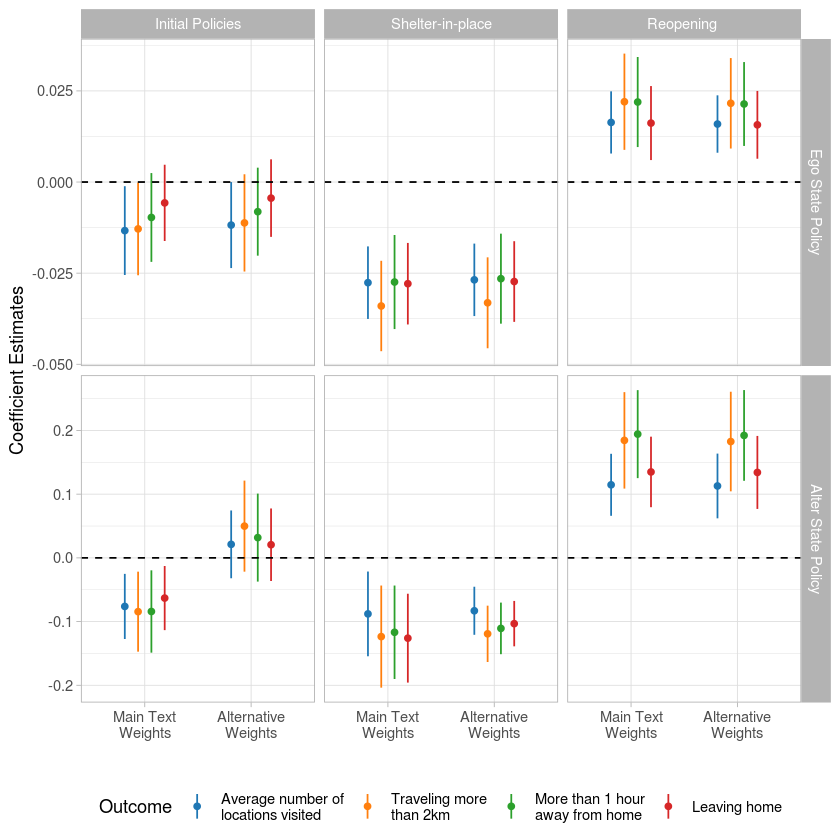

In [54]:
pn <- c('p1sdp' = "Initial Policies",
        'p2shp' = "Shelter-in-place",
        'p3rop' = "Reopening ",
        'A' = "Ego State Policy",
        'B' = "Alter State Policy")

coefs %>%
    filter(str_detect(var, 'p[123]')) %>%
    mutate(var = str_replace(var, 'p[23]$', 'p'),
           dv  = factor(dv, levels = c('log_mcbgv', 'log_pgt2kmt', 'log_pgt1hafh', 'log_pnchd')),
           model = factor(model, levels = c('Main Text\nWeights', 'Alternative\nWeights')),
           type = ifelse(str_detect(var, 'stalter'), 'B', 'A'),
           var = str_replace(var, 'stalter_', '')) %>%
    ggplot(aes(x = model, y = estimate, color = dv)) + 
    geom_point(position = position_dodge(width = 0.5)) + 
    geom_linerange(aes(ymin = estimate - 1.98 * se,
                       ymax = estimate + 1.98 * se),
                   position = position_dodge(width = 0.5)) +
    facet_grid(type~var, scales = 'free', labeller = as_labeller(pn)) +
    scale_color_d3(labels = c('Average number of\nlocations visited', 
                              'Traveling more\nthan 2km', 
                              'More than 1 hour\naway from home', 
                              'Leaving home')) +
    xlab('') + 
    ylab('Coefficient Estimates') +
    labs(color = 'Outcome') +
    geom_hline(aes(yintercept = 0), linetype = 2) +
    theme_light() + 
    theme(legend.position = 'bottom')